In [1]:
from __future__ import division
from IO import *
from cycler import cycler
import matplotlib as mpl
%matplotlib inline
from numba import autojit

%load_ext autoreload
%autoreload 2

today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)
    
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH(cortex)

# styling
gammaColor = '#00cc99'

def xax(gamma, duration):
    x= np.arange(0,(duration-1)/1000,(duration)/1000/len(gamma) )
    return x

@autojit
def resonanceFS(F, tauv=15):
    T = 2000
    dt = 1
    t = np.arange(0, T, dt)
    F = np.logspace(0.5, 2.3, 200)

    res_var = np.empty(len(F), dtype=np.float64)
    b = 2
    for k, f in enumerate(F):
        A = 0.01
        I = A * np.cos(2 * np.pi * f * t / 1000)
        res_v = []
        res_u = []
        u = 0
        t_rest = 0

        # izh neuron model for cortical fast spiking neurons (that burst)
        v = -60
        for i in range(len(t)):
            v += dt / tauv * ((v + 60) * (v + 50) - 20 * u + 8 * I[i])
            u += dt * 0.044 * ((v + 55) - u)
            if v > 25:
                v = -40
                u += 50
            if i * dt > 1500:
                res_v.append(v / A)

        var = np.var(res_v)
        #         var = np.max(res_v)-np.min(res_v)
        res_var[k] = var
    return res_var



In [45]:
# #-------------------------------
# # PARAMS SEARCH
# #-------------------------------
c = cortex
c.N = 100
c.g = 10
c.d1 = 10
c.d2 = 60000
c.d3 = 10
c.initTime()
c.sigma = 60
c.WII = 1400 #2800
c.S = 100
c.model = "gp-izh-subnetworks"
c.glob = 0

# shared weights
c.sG = 15
c.sWII = 0

c.FACT = 1
c.r=0

c.ratio = 15
c.LTD  = 1e-0*4.7e-6 * c.FACT * c.N
c.LTP = c.ratio * c.LTD

c.tauv=95

c.with_currents = True

# for S in np.arange(50,400,50):
#     Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N,0, G, S, d1, d2, d3, before, after, sigma, \
# WII, LTP, LTD) for G in np.linspace(1,9,"8))

sWIIList = [10]
sGList = [0,1,5,10,15,20,25]
LTDList = [1e-0*4.7e-6 * c.FACT * c.N]
taulist = np.arange(15,95,10)

# cortex.runSimulation()

# c.readSimulation()
# gr.plotWeights(tauv = c.tauv)


# for d2 in [60000]:
#         for sWII in sWIIList:
#             for sG in sGList:
#                 for LTD in LTDList:
#                     LTP = ratio * LTD
#                     Parallel(n_jobs=8)(delayed(cortex.runSimulation)(N=N,i=0, g=G, S=S, 
#                                                                      d1=d1, d2=d2, d3=d3, 
#                                                                      before=before, after=after,
#                                          s=sigma, WII=WII, LTP=LTP, LTD=LTD, 
#                                                                      model=model, r=r, glob=glob, 
#                                                                      sG=sG, sWII=sWII, tauv=tauv) for tauv in taulist)
                    
df = pd.DataFrame(columns = ['tauv', 'd2','sWII', 'sG', 'LTD',
                             'maxBegin', 'argmaxBegin', 'maxEnd', 'argmaxEnd',
                            'f1Begin', 'p1Begin', 'f2Begin', 'p2Begin', 
                             'f1End', 'p1End', 'f2End', 'p2End', 'key'])
i=0
for c.tauv in taulist:
    for c.d2 in [60000]:
        for c.sWII in sWIIList:
            for c.sG in sGList:
                for c.LTD in LTDList:
                    c.LTP = c.ratio * c.LTD
                    c.readSimulation()
                    csd = gr.valCSD()
                    if c.tauv <=35 and c.sG<=10:
                        key=-2
                    elif c.tauv>35 and c.sG<=10:
                        key=-1
                    elif c.tauv<=35 and c.sG>10:
                        key=2
                    elif c.tauv>35 and c.sG>10:
                        key=1
                    else:
                        key=0
                    df.loc[i] = [c.tauv, c.d2, c.sWII, c.sG, c.LTD>1e-8, 
                                 csd['maxBegin'], csd['argmaxBegin'], csd['maxEnd'], csd['argmaxEnd'],
                                csd['f1Begin'][0], csd['f1Begin'][1], csd['f2Begin'][0], csd['f2Begin'][1],
                                csd['f1End'][0], csd['f1End'][1], csd['f2Begin'][0], csd['f2End'][1],
                                key]
                    i+=1
    
df.to_csv(DIRECTORY+'df.csv')


In [46]:
df = pd.read_csv(DIRECTORY+'df.csv')

In [47]:
df.head()

,Unnamed: 0,tauv,d2,sWII,sG,LTD,maxBegin,argmaxBegin,maxEnd,argmaxEnd,f1Begin,p1Begin,f2Begin,p2Begin,f1End,p1End,f2End,p2End,key
0,0,15.0,60000.0,10.0,0.0,True,49.355029,11.0,20.400981,20.400981,43.956044,23.514893,41.958042,21.596053,53.946054,19.007617,41.958042,18.666811,-2.0
1,1,15.0,60000.0,10.0,1.0,True,22.974307,11.0,56.729457,56.729457,41.958042,23.452430,39.960040,20.086245,41.958042,24.543798,39.960040,19.842381,-2.0
2,2,15.0,60000.0,10.0,5.0,True,158.814090,11.0,82.355950,82.355950,45.954046,22.981634,45.954046,24.039090,45.954046,22.737314,45.954046,21.900756,-2.0
3,3,15.0,60000.0,10.0,10.0,True,144.703488,10.0,122.365323,122.365323,43.956044,22.500462,43.956044,21.457205,43.956044,24.453717,43.956044,24.757712,-2.0
4,4,15.0,60000.0,10.0,15.0,True,287.280821,10.0,104.907562,104.907562,39.960040,27.175034,39.960040,26.948977,45.954046,21.937051,39.960040,21.019396,2.0


In [48]:
def plotCoherence(df, sG=0, ax=None):
    df_sliced = df[(df['LTD']==True) & (df['sG']==sG)]
    data = df_sliced[['tauv', 'maxBegin', 'maxEnd']].get_values()
    if ax is None : 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
    im = ax.scatter(np.ones(len(data)), data[:,1], c=np.arange(len(data)))
    ax.scatter(np.ones(len(data))*2, data[:,2], c=np.arange(len(data)))
    ax.set_title('peak coherence sG=%d'%sG)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['start', 'end'], rotation='vertical')


def plotArgCoherence(df, sG=0, ax=None):
    df_sliced = df[(df['LTD']==True) & (df['sG']==sG)]
    data = df_sliced[['tauv', 'argmaxBegin', 'argmaxEnd']].get_values()
    if ax is None : 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
    ax.scatter(np.ones(len(data)), data[:,1], c=np.arange(len(data)))
    ax.scatter(np.ones(len(data))*2, data[:,2], c=np.arange(len(data)))
    ax.set_title('peak frequency sG=%d'%sG)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['start', 'end'], rotation='vertical')
    return ax

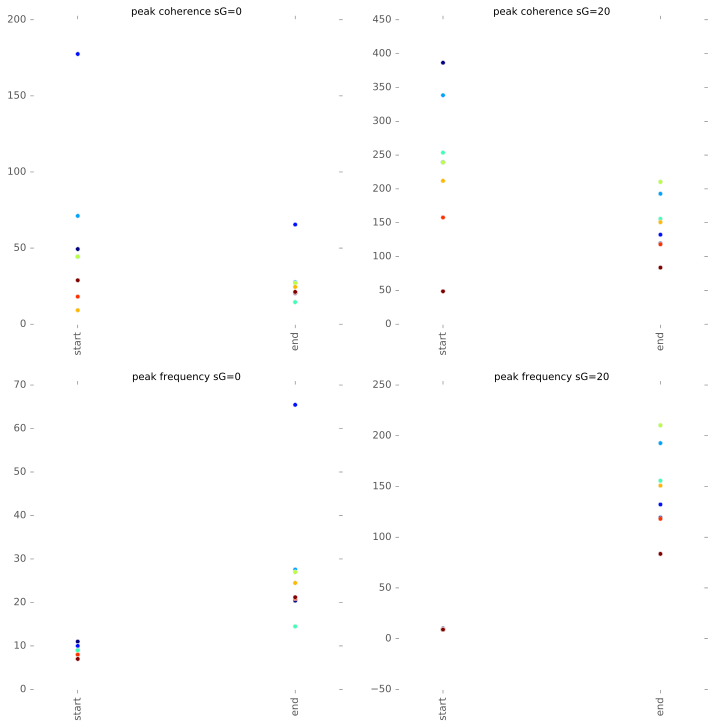

In [49]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plotCoherence(df,sG=0, ax=ax1)
plotCoherence(df,sG=20, ax=ax2)
plotArgCoherence(df,sG=0, ax=ax3)
plotArgCoherence(df,sG=20, ax=ax4)
plt.savefig(DIRECTORY + 'cor.png')

In [50]:
def plotSGCoherence(df, tauv=0, ax=None):
    df_sliced = df[(df['LTD']==True) & (df['tauv']==tauv)]
    data = df_sliced[['sG', 'maxBegin', 'maxEnd']].get_values()
    if ax is None : 
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
    im = ax.plot(data[:,0], data[:,1], label='start')
    im = ax.plot(data[:,0], data[:,2], label='end')
    ax.legend()
    ax.set_title('coherence vs sG, tauv=%d'%tauv)

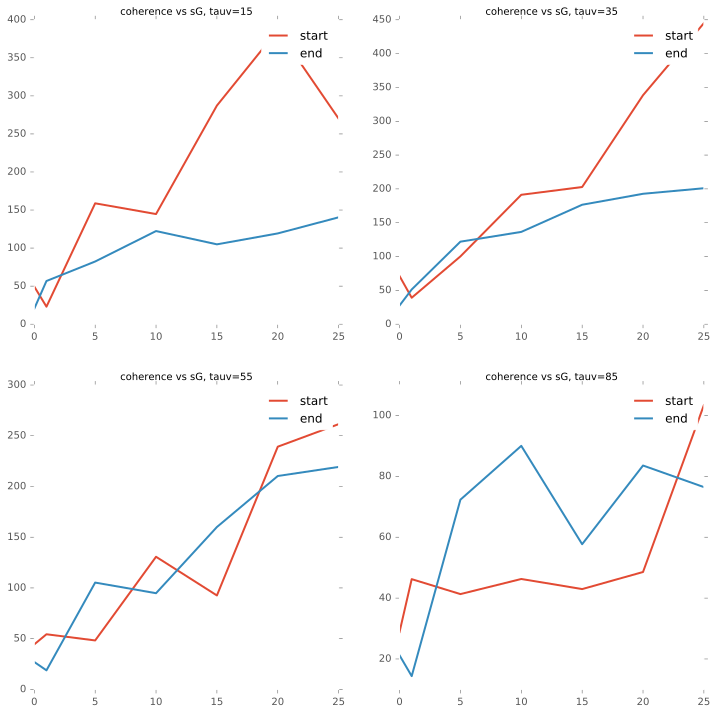

In [51]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
plotSGCoherence(df,tauv=15, ax=ax1)
plotSGCoherence(df,tauv=35, ax=ax2)
plotSGCoherence(df,tauv=55, ax=ax3)
plotSGCoherence(df,tauv=85, ax=ax4)
plt.savefig(DIRECTORY + 'corSG.png')

0

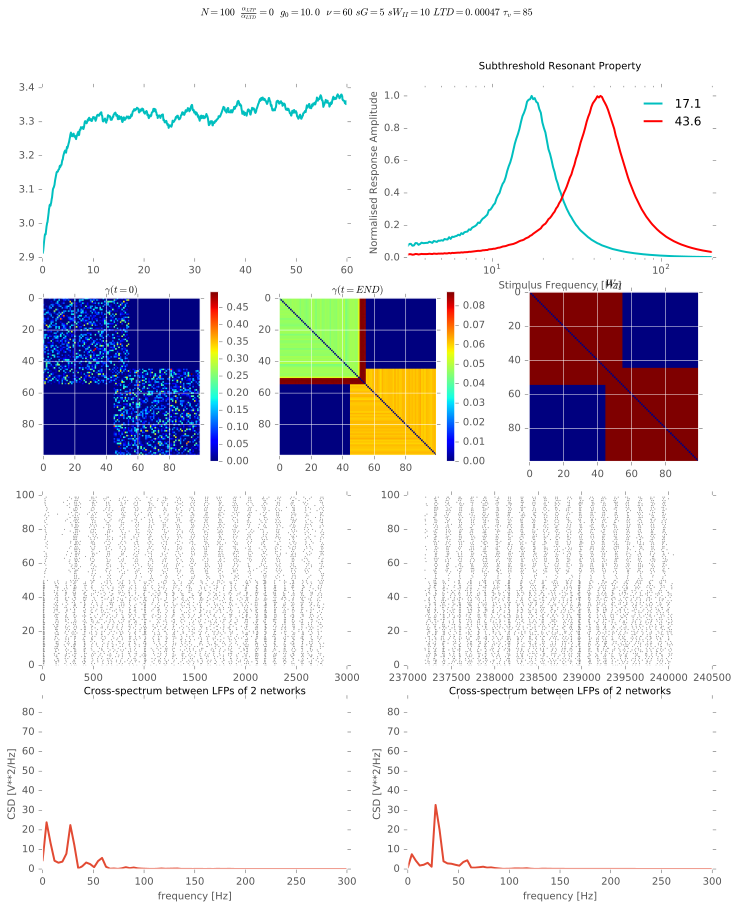

In [52]:
c.tauv = 85
c.sG = 5
c.sWII = 10
c.readSimulation()
gr.plotWeights(c.tauv)

In [53]:
print(gr.fourier(c.i1[0:4000]))
print(gr.fourier(c.i2[0:4000]))
print(gr.fourier(c.i1[-4000:-1]))
print(gr.fourier(c.i2[-4000:-1]))

[47.952047952047955, 18.646671756647169]
[27.972027972027973, 23.444881426201633]
[29.970029970029969, 22.681858372014389]
[29.970029970029969, 22.059633857350814]


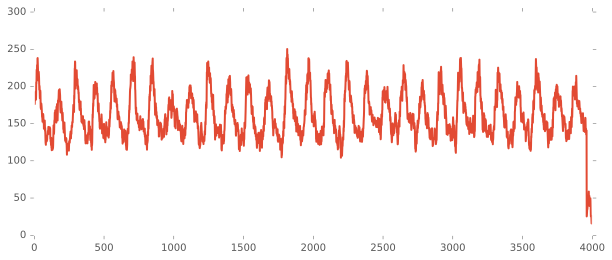

In [54]:
plt.plot(c.i2[-4000:-1])

/Users/GP1514/Dropbox/ICL-2014/Code/C-Code/cortex/notebooks/IO.py:462: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  plt.imshow(np.ma.masked_values(zr, 0), cmap=cmap)


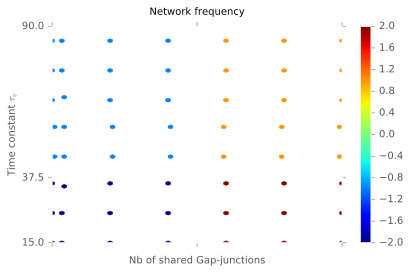

In [57]:
###################################
# frequency
###################################
fig = plt.figure(figsize=(6,4))
extent = [np.min(df['sG']), np.max(df['sG']), np.min(df['tauv']), np.max(df['tauv'])]
dataframe = df[(df['LTD']==True)]
#dataframe['logpower']= (dataframe['power']).apply(np.log10)


# power
# df_sliced = df[(dataframe['logpower']>-1.07) & (dataframe['logpower']<-1.038)]

ax = fig.add_subplot(111)

title = r'Network frequency'
filename = "global_gap_junctions_bursting.pdf" 
column = 'key'

ax = gr.plotDiagramCSD(fig, ax, dataframe, title, column, filename, extent=extent, cmap = plt.cm.jet)
ax.set_xticklabels([])

plt.savefig(DIRECTORY + 'cluster.pdf')

In [56]:
df[(df['tauv'])]

KeyError: '[ 15.  15.  15.  15.  15.  15.  15.  25.  25.  25.  25.  25.  25.  25.  35.\n  35.  35.  35.  35.  35.  35.  45.  45.  45.  45.  45.  45.  45.  55.  55.\n  55.  55.  55.  55.  55.  65.  65.  65.  65.  65.  65.  65.  75.  75.  75.\n  75.  75.  75.  75.  85.  85.  85.  85.  85.  85.  85.] not in index'